### Edge signed graph problem

Let $G = (V,E,s)$ be a signed graph and $k$ a positive scalar satisfying $k \in \{1, \ldots, n\}$.

An edge $e \in E$ is called negative if $s(e) = −1$ and positive if $s(e) = +1$. 

Let $E^{-}$ and $E^{+}$ denote, respectively, the sets of negative and positive edges in a signed graph. 

For a vertex set $S \subseteq V$ , let $E[S] = \{ (i,j) \in E \ | \ i,j \in S \}$ denote the subset of edges induced by $S$.

Let $S_i$ the partition $i$ the $G$.

$
x_{vi} = 
\begin{cases}
1, & \text{ if } v \in S_i \\
0, & \text{otherwise}. 
\end{cases} 
\forall v \in V,\forall i \in [k]
$

$
y_{uv} = 
\begin{cases}
1, & \text{ if } (u,v) \text{ is removed} \\
0, & \text{ otherwise.} 
\end{cases} 
\forall (u,v) \in E
$

$$
\begin{align}
\min \quad & \sum\limits_{uv \in E} y_{uv} & \\
\text{s.t} \quad & \sum_{i \in [k]} x_{vi} \geq 1 & \forall v \in V  \\
& x_{ui} + x_{vi} \leq 1 + y_{uv} & \forall uv \in E^{-}, \forall i \in [k] \\
& x_{ui} \geq x_{vi} - y_{uv} & \forall uv \in E^{+}, \forall i \in [k] \\
& x_{vi} \geq x_{ui} - y_{uv} & \forall uv \in E^{+}, \forall i \in [k] \\
& x_{vi} \in \{0,1\} & \forall v \in V, \forall i \in [k] \\
& y_{vu} \in \{0,1\} & \forall uv \in E 
\end{align}
$$

In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp

In [30]:
def edgesEN(G):
    EP = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    EN = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0]

    return EP, EN

In [31]:
def setVK(G,k):
    nodes = G.nodes()
    vk = []
    for i in nodes:
        for j in range(k):
            a = (i,j)
            vk.append(a)

    return vk

In [32]:
def read_instance(instance):
    with open(instance, 'r') as file: 
        lines = file.readlines()

    lines = [a.strip() for a in lines]

    values = lines[0].split()
    n, m = int(values[0]), int(values[1])

    #print("n =", n)
    #print("m =", m)

    G = nx.Graph()

    for k in range(n):
        G.add_node(k)

    for e in range(1,m+1):
        values = lines[e].split()
        i, j, val = int(values[0]), int(values[1]), int(values[2])
        G.add_edge(i, j, weight=val)

    return G


In [33]:
def plotGraph(G, pos):
    plt.figure(figsize=(25, 20))
    nx.draw_networkx(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [34]:
def position(G):
    #seed = 20532
    pos = nx.spring_layout(G)
    #pos=nx.random_layout(G)
    #pos=nx.circular_layout(G)
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    #pos = nx.spring_layout(G, seed=seed)

    return pos

In [35]:
def edge_formulation(G, k, VK, EP, EN):

    nodes = G.nodes()
    edges = G.edges()
    K = range(k)
    
    method = "mip"

    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges,vtype=gp.GRB.BINARY, name="y")
        x = model.addVars(VK,vtype=gp.GRB.BINARY, name="x")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints
 
    for v in nodes:
        constr = 0
        for i in K:
            constr += x[(v,i)] 
        model.addConstr(constr >= 1.0, "constr2")

    for e in EN:
        for i in K:
            model.addConstr(x[(e[0],i)] + x[(e[1],i)] <= 1 + y[(e[0],e[1])], "constr3")


    for e in EP:
        for i in K:
            model.addConstr(x[(e[0],i)] >= x[(e[1],i)] - y[(e[0],e[1])], "constr4")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[1],i)] >= x[(e[0],i)] - y[(e[0],e[1])], "constr5")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')


    model.write("edge_mip.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    xval = {}
    for v in VK:
        xval[v] = x[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    Ex = []
    for key, value in xval.items():
        if value > 0.5:
            Ex.append(key)

    Ey = []
    for key, value in yval.items():
        if value > 0.5:
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey

In [36]:
def graph_ex():
    G = nx.Graph()
    #G.add_nodes_from([1,2,3,4,5,6])
    edges = [(1,2,+1), (1,4,-1), (2,3,-1), (2,4,-1), (2,5,-1), (2,6,+1), (3,5,+1), (3,6,-1), (4,5,+1), (5,6,-1)]
    G.add_weighted_edges_from(edges)

    return G

In [37]:
def plot_graph_ex(G):
    #nx.draw_planar(G, with_labels = "True")
    pos = {1:(0,0), 2:(2,0), 3:(4,0), 4:(0,-1), 5:(2,-1), 6:(4,-1)}
    nx.draw(G, pos, with_labels="True")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()

In [38]:
#random_n20_k2_pos30_neg5_err5_1
#random_n20_k2_pos30_neg5_err5_2
#random_n20_k2_pos30_neg5_err5_3
#random_n20_k2_pos30_neg5_err5_4
#random_n20_k2_pos30_neg5_err5_5

#random_n60_k2_pos30_neg5_err5_1
#random_n60_k2_pos30_neg5_err5_2
#random_n60_k2_pos30_neg5_err5_3
#random_n60_k2_pos30_neg5_err5_4
#random_n60_k2_pos30_neg5_err5_5

# random_n60_k3_pos30_neg5_err5_1

# random_n60_k4_pos30_neg5_err5_1

# random_n60_k5_pos30_neg5_err5_1

#instance = f"../data/kmbs/instances/RANDOM/random_n60_k3_pos30_neg5_err5_1.g"
#G = read_instance(instance)

G = graph_ex()

n = G.number_of_nodes()
m = G.number_of_edges()

print("n =", n)
print("m =", m)

n = 6
m = 10


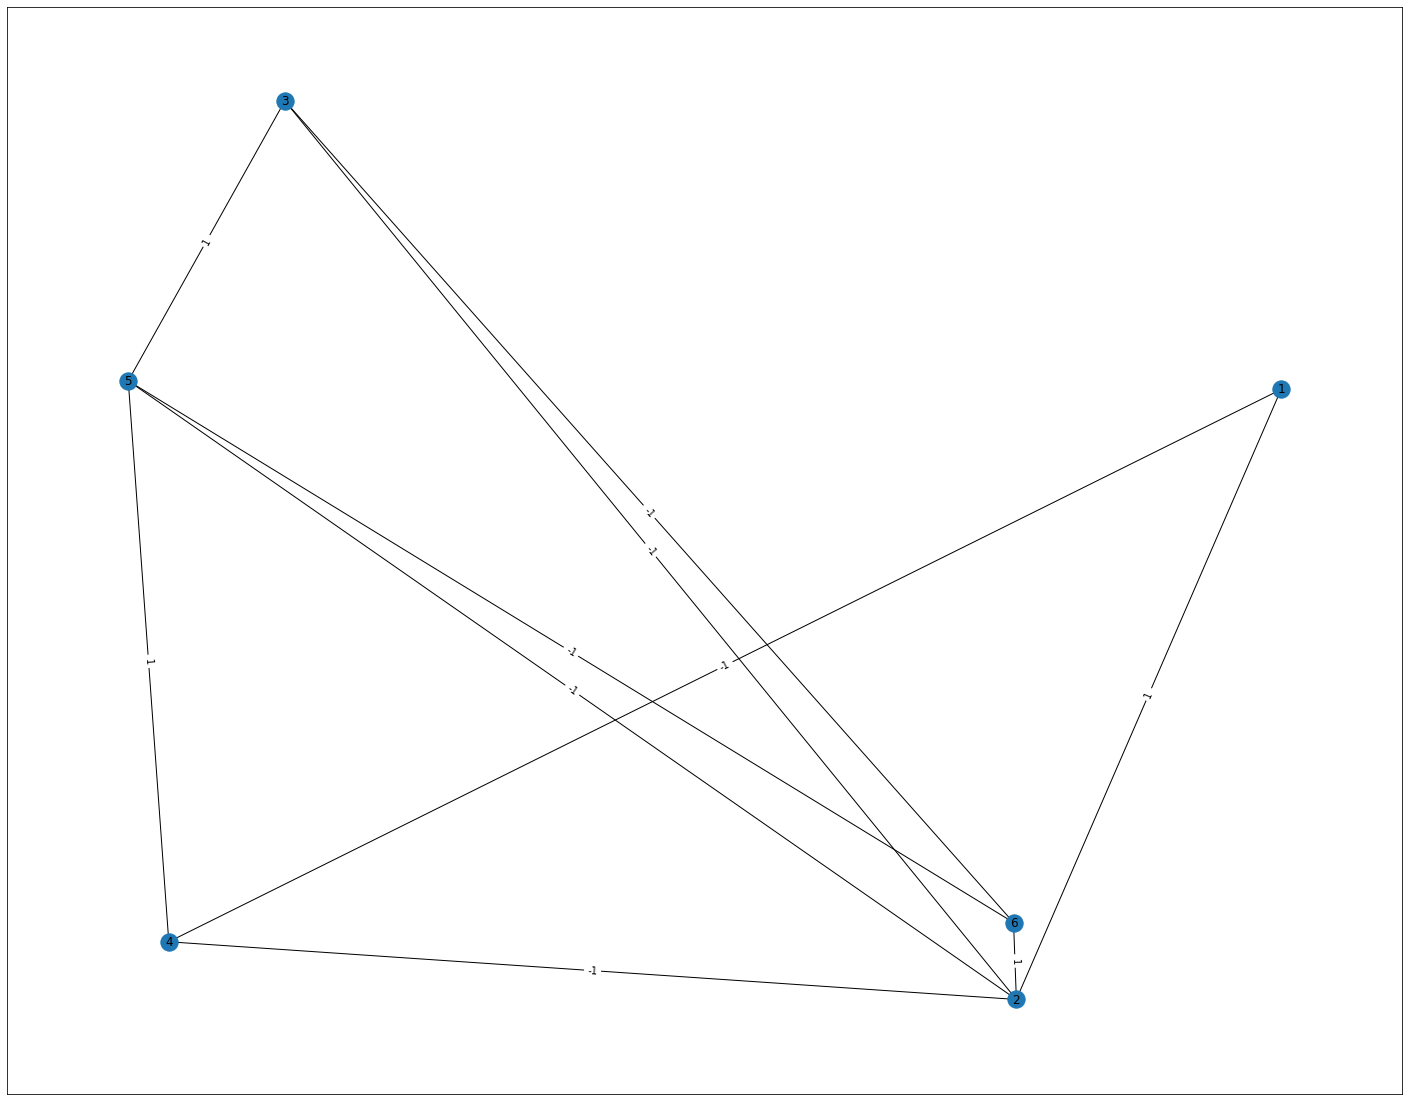

In [39]:
pos = position(G)
plotGraph(G,pos)

In [40]:
EP, EN = edgesEN(G)
HP = nx.Graph()
HN = nx.Graph()

HP.add_nodes_from(G)
HN.add_nodes_from(G)

HP.add_edges_from(EP)
HN.add_edges_from(EN)

print(f"G : #nodes= {G.number_of_nodes()}, #edges = {G.number_of_edges()}")
print(f"HP : #nodes= {HP.number_of_nodes()}, #edges = {HP.number_of_edges()}")
print(f"HN : #nodes= {HN.number_of_nodes()}, #edges = {HN.number_of_edges()}")

G : #nodes= 6, #edges = 10
HP : #nodes= 6, #edges = 4
HN : #nodes= 6, #edges = 6


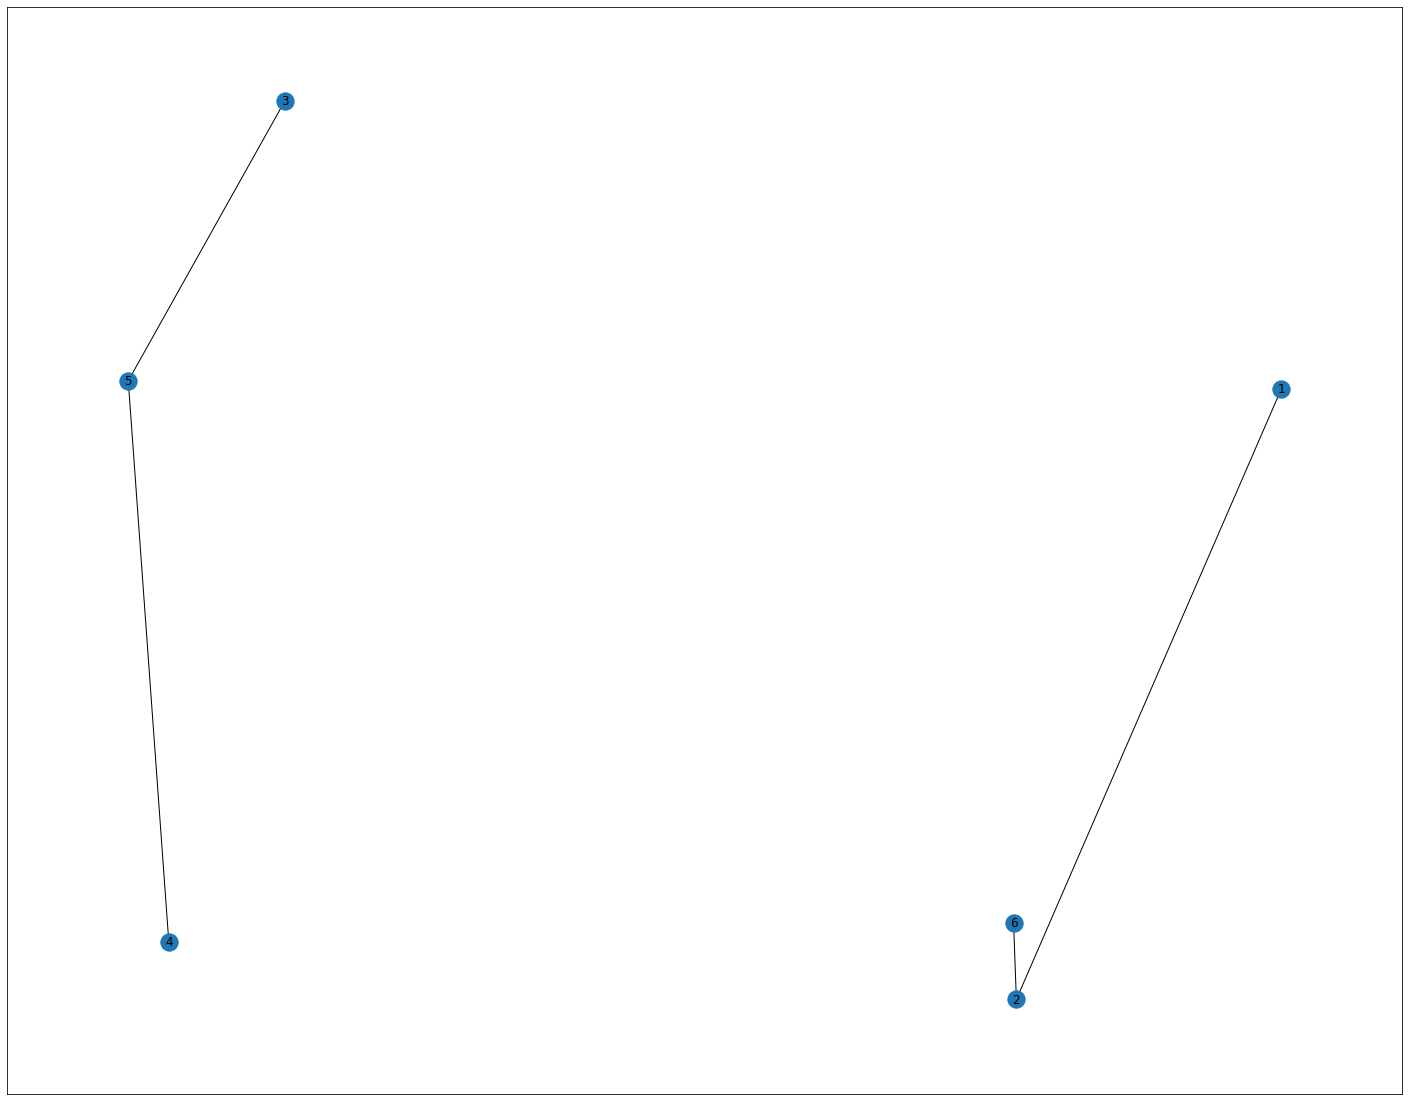

In [41]:
plotGraph(HP, pos)

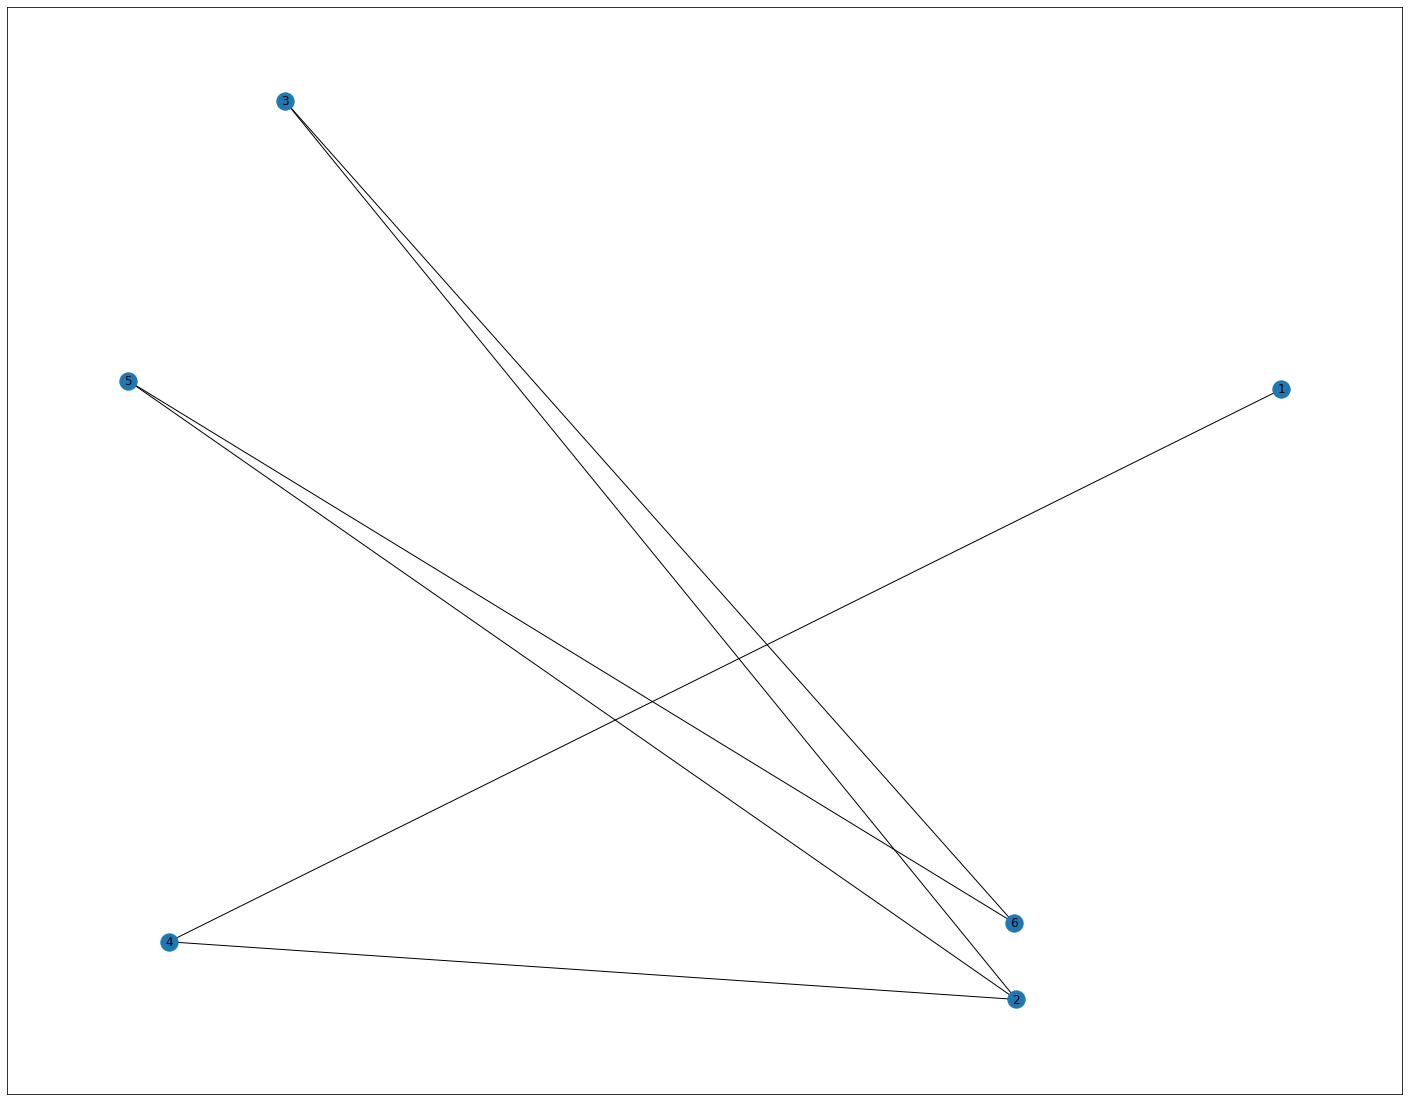

In [42]:
plotGraph(HN,pos)

In [43]:
k = 3
VK = setVK(G, k)

objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey = edge_formulation(G, k, VK, EP, EN)
    
print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)


ub =  0.0
time =  0.0014700889587402344
status =  1
lb =  0.0
gap =  0.0
nodes =  1.0


In [44]:
print(Ex)

[(1, 0), (2, 0), (4, 2), (3, 2), (5, 2), (6, 0)]


In [45]:
print(Ey)

[]


In [46]:
for i in range(k):
    print(f"particao {i}: ", end="")
    for v in Ex:
        if v[1] == i:
            print(v[0], end=", ")
    print()

particao 0: 1, 2, 6, 
particao 1: 
particao 2: 4, 3, 5, 


In [47]:
partition = []
for i in range(k):
    a = []
    for v in Ex:
        if v[1] == i:
            a.append(v[0])
    partition.append(set(a))
    
#partition

In [48]:
nx.community.is_partition(G, partition)

True

In [49]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

for key, value in partition_map.items():
    print(f"{key}: {value}")

1: 0
2: 0
6: 0
3: 2
4: 2
5: 2


In [50]:
color_map = []
for node in G:
    if partition_map[node] == 0:
        color_map.append('gray')
    elif partition_map[node] == 1:
        color_map.append('green')
    else:
        color_map.append('yellow')

#node_colors = [partition_map[n] for n in G.nodes]

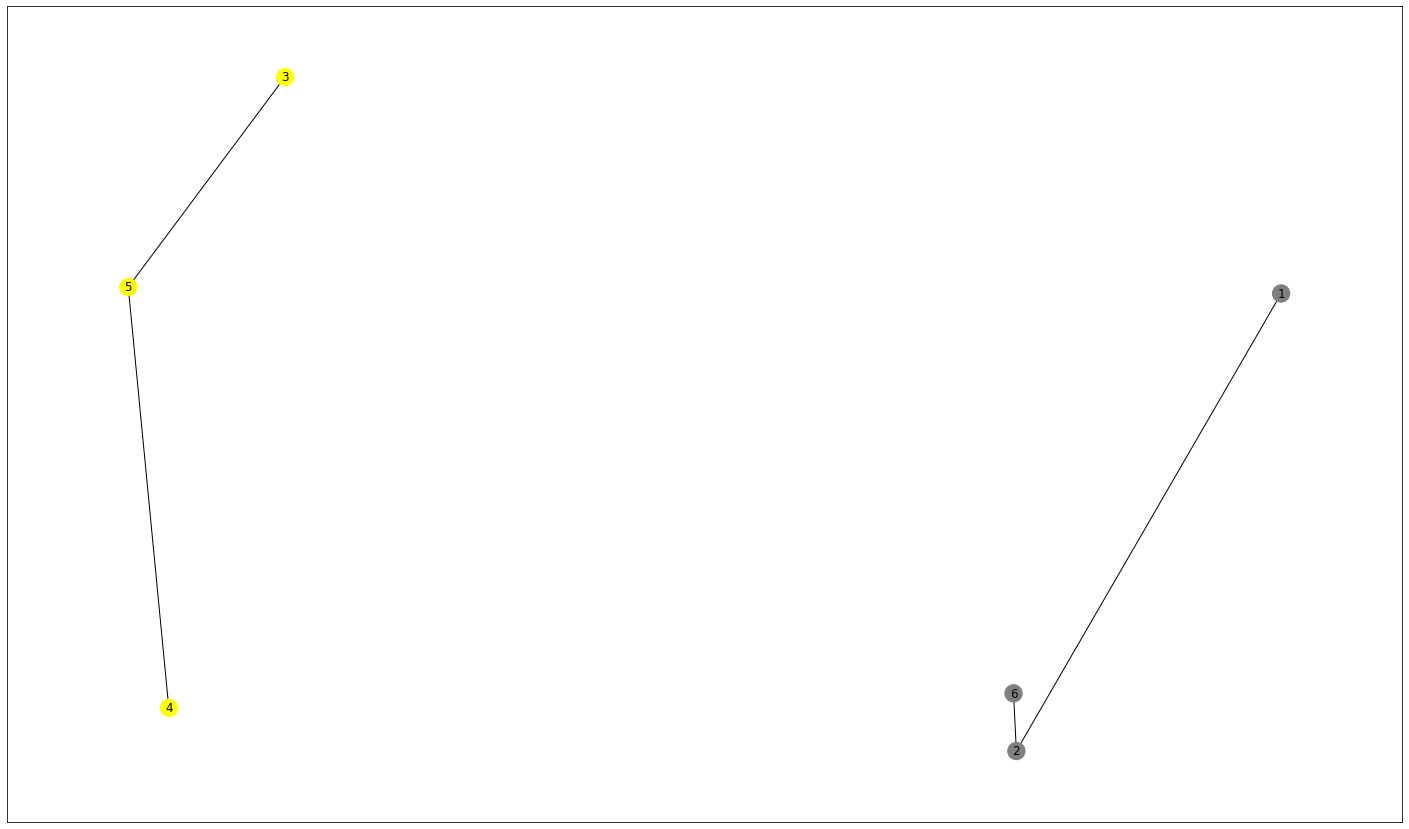

In [51]:
HP.remove_edges_from(Ey)
plt.figure(figsize=(25, 15))        
nx.draw_networkx(HP, pos, node_size=300, node_color=color_map, with_labels=True)
plt.show()

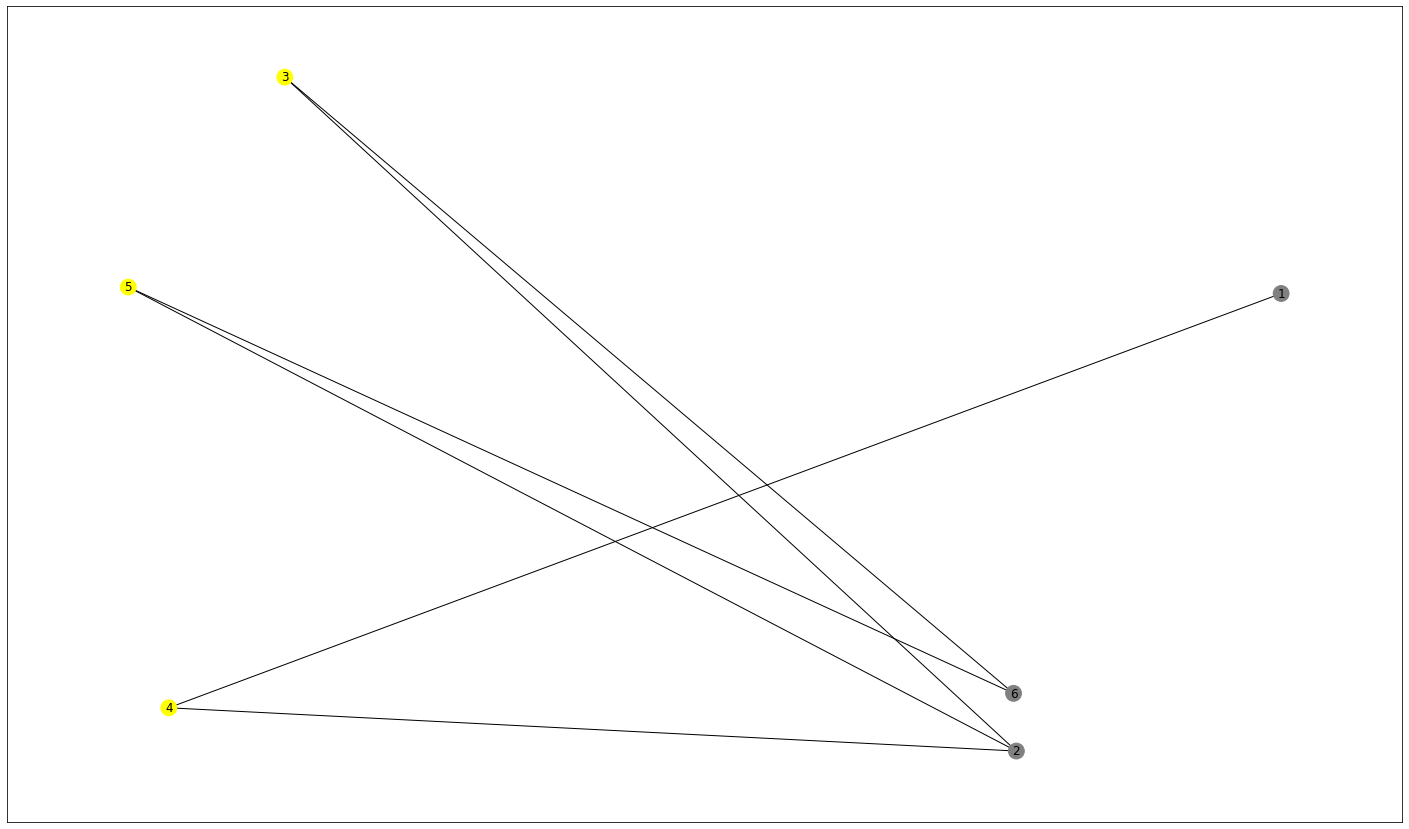

In [52]:
HN.remove_edges_from(Ey)
plt.figure(figsize=(25, 15))        
nx.draw_networkx(HN, pos, node_size=250, node_color=color_map, with_labels=True)
plt.show()

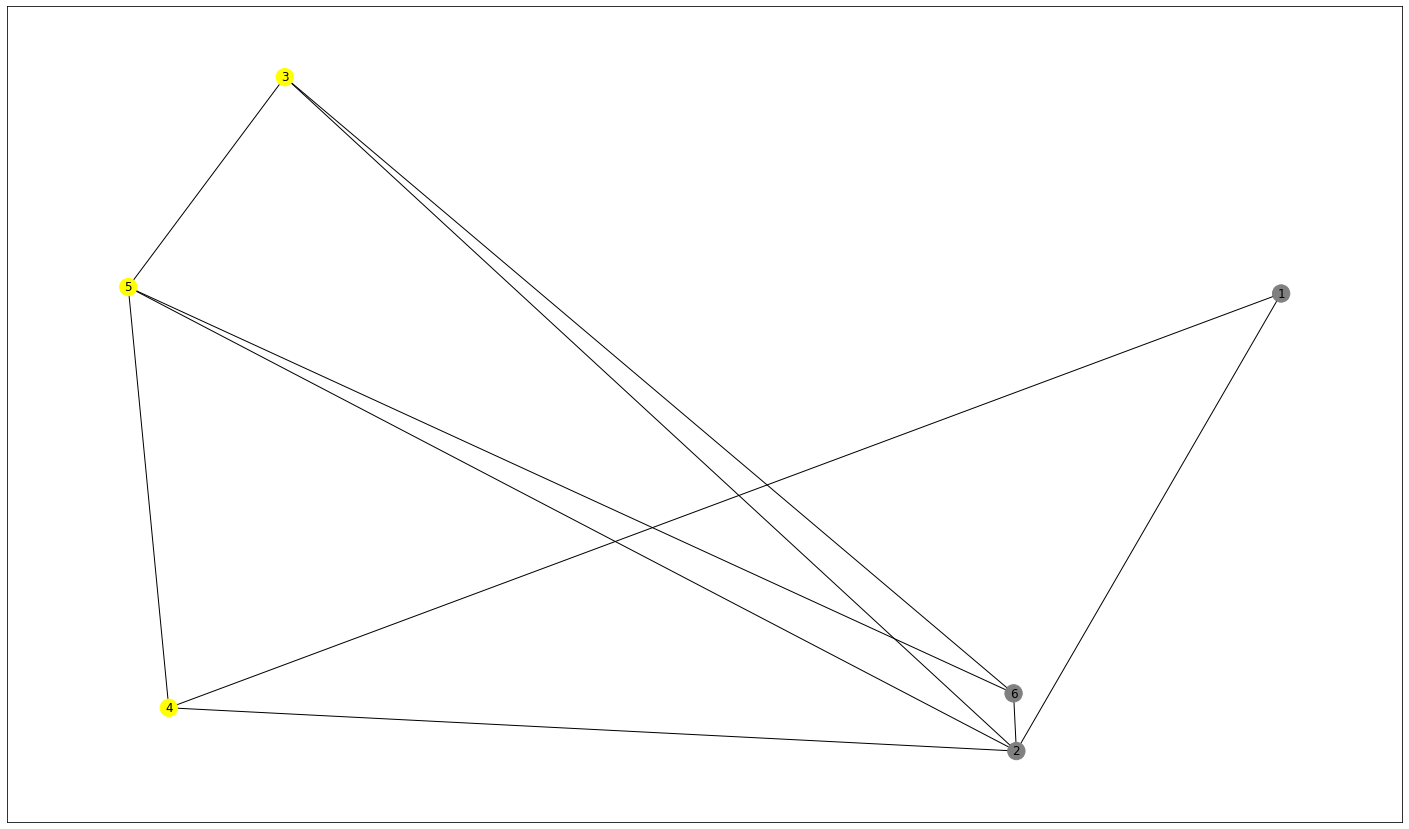

In [53]:
plt.figure(figsize=(25, 15))        
nx.draw_networkx(G, pos, node_size=300, node_color=color_map, with_labels=True)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

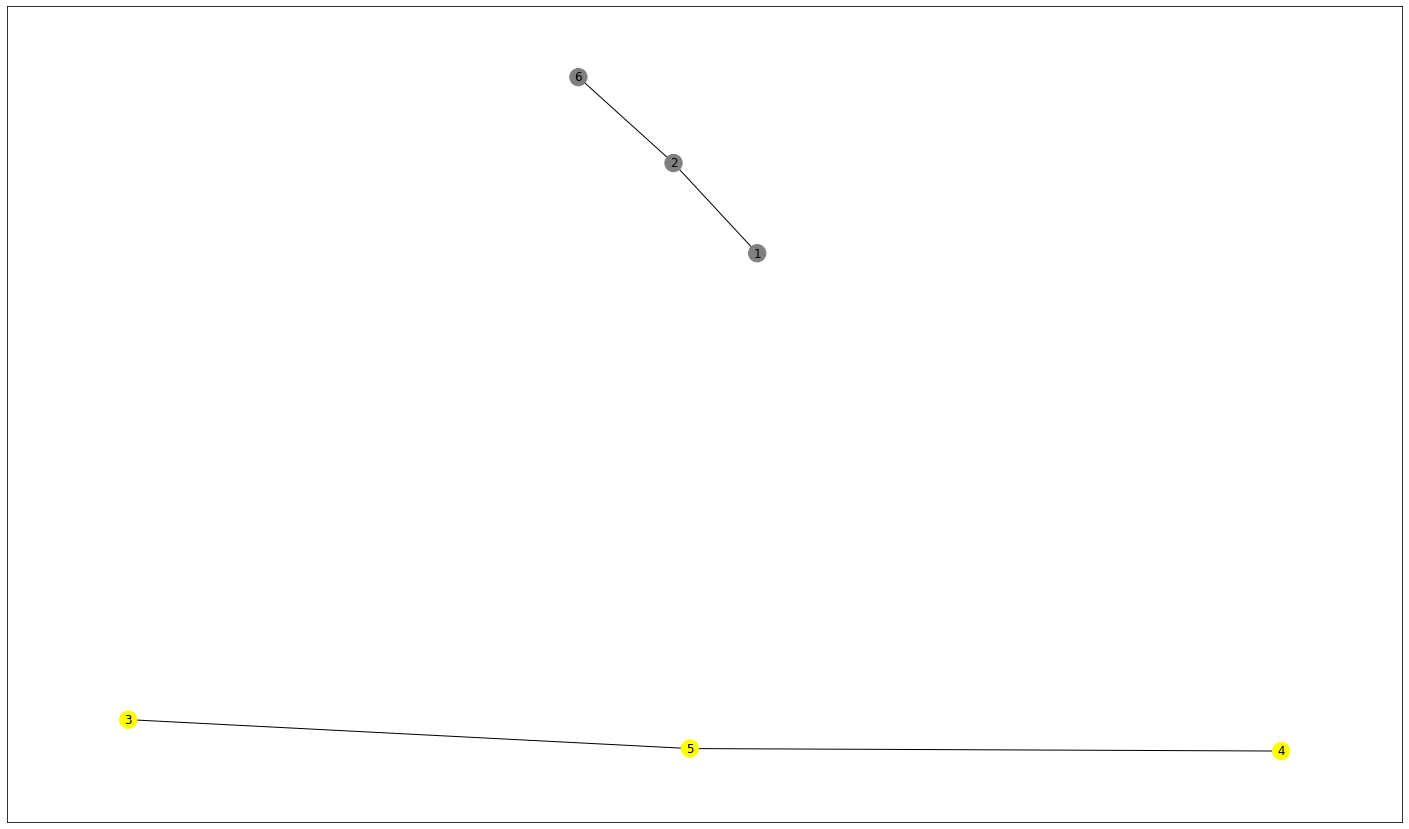

In [54]:
seed = 20532
plt.figure(figsize=(25, 15))        
pos1 = nx.spring_layout(HP, seed=seed)
nx.draw_networkx(HP, pos1, node_size=300, node_color=color_map, with_labels=True)
plt.show()